## Difference-in-Differences (DiD) Analysis

Having confirmed (or adjusted for) parallel pre-trends, we now estimate the **treatment effect** of the expulsion initiative using two levels of aggregation:
1. **Nationwide** (Swiss vs. Foreigners, aggregated 2009–2024)  
2. **Canton-panel** (26 cantons × 2 groups × years)

### 1. Nationwide DiD

We estimate:

$\log(\text{crime\_rate}_{gt})
= \alpha + \lambda \times T_g + \gamma \times P_t
\;+\;\beta\,(T_{g}\times P_{t})
\;+\;\varepsilon_{gt}.$

In [139]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Nationwide (aggregated) DiD 
df_agg = pd.read_excel('/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned.xlsx')
df_agg['T'] = (df_agg['group']=="Foreigner").astype(int)
df_agg['P'] = (df_agg['year']>=2017).astype(int)
df_agg['log_rate'] = np.log(df_agg['crime_rate_per_100k'])

model_nat = smf.ols("log_rate ~ T + P + T:P", data=df_agg).fit()
print("Nationwide DiD")
print(model_nat.summary())

Nationwide DiD
                            OLS Regression Results                            
Dep. Variable:               log_rate   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     318.4
Date:                Sun, 11 May 2025   Prob (F-statistic):           1.87e-19
Time:                        18:44:58   Log-Likelihood:                 26.598
No. Observations:                  28   AIC:                            -45.20
Df Residuals:                      24   BIC:                            -39.87
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0741      0.038    1

### 2. Nationwide DiD with Group & Year Fixed Effects

To control for average differences across groups and over time, we estimate:

$\log(\text{crime\_rate}_{gt})
= \alpha
\;+\;\beta\,(T_{g}\times P_{t})
\;+\;\underbrace{\gamma_{g}}_{\text{group FE}}
\;+\;\underbrace{\lambda_{t}}_{\text{year FE}}
\;+\;\varepsilon_{gt}.$
- This absorbs any group-specific level and common time shocks.
- We still interpret the $T\times P$ coefficient as the causal effect.


In [140]:
#2) Nationwide aggregated DiD w fixed effects
#Model: log_crime_rate = α + γ_group + λ_year + β·(T × P) + ε  
model = smf.ols("log_rate ~ T:P + C(group) + C(year)", data=df_agg).fit()
print("Nationwide DiD (w/ Fixed Effects)")
print(model.summary())

Nationwide DiD (w/ Fixed Effects)
                            OLS Regression Results                            
Dep. Variable:               log_rate   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     315.7
Date:                Sun, 11 May 2025   Prob (F-statistic):           3.27e-13
Time:                        18:44:58   Log-Likelihood:                 58.401
No. Observations:                  28   AIC:                            -84.80
Df Residuals:                      12   BIC:                            -63.49
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Inte

### 3. Canton-Panel DiD (Simple)

Using the canton-level panel (only cantons with ≥6 valid pre/post obs):

$\log(\text{crime\_rate}_{cgt})
= \alpha
\;+\;\beta\,(T_{g}\times P_{t})
\;+\;FE_{c}
\;+\;FE_{t}
\;+\;FE_{g}
\;+\;\varepsilon_{cgt}.$

- $c$ indexes cantons.  
- We cluster standard errors at the **canton** level.


In [141]:
# 3) Canton-panel DiD -----------------------------------------
df_ct = pd.read_excel("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned_by_canton.xlsx")

good = []
for c in df_ct['canton'].unique():
    sub = df_ct[df_ct['canton']==c]
    good.append(c)
df_ct = df_ct[df_ct['canton'].isin(good)].copy()

# prepare DiD variables
df_ct = df_ct[df_ct['crime_rate_per_100k']>0]
df_ct['log_rate'] = np.log(df_ct['crime_rate_per_100k'])
df_ct['T'] = (df_ct['group']=="Foreigner").astype(int)
df_ct['P'] = (df_ct['year']>=2017).astype(int)
df_ct['T_P'] = df_ct['T'] * df_ct['P']
df_ct['t'] = df_ct['year'] - df_ct['year'].min()
df_ct['T_t'] = df_ct['T'] * df_ct['t']

# 3a) Simple canton panel DiD
mod1 = smf.ols("log_rate ~ T_P + C(canton) + C(year) + C(group)", data=df_ct).fit(cov_type='cluster', cov_kwds={'groups': df_ct['canton']})

print("\nCanton-panel DiD (simple)")
print(mod1.summary())


Canton-panel DiD (simple)
                            OLS Regression Results                            
Dep. Variable:               log_rate   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     182.1
Date:                Sun, 11 May 2025   Prob (F-statistic):           1.62e-19
Time:                        18:44:58   Log-Likelihood:                -278.76
No. Observations:                 556   AIC:                             633.5
Df Residuals:                     518   BIC:                             797.7
Df Model:                          37                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 15
  warnings.warn('covariance of constraints does not have full '


### 4. Augmented Canton-Panel DiD (with Group-Specific Trend)

To soak up any residual slope differences, we add a group‐specific time trend:

$\log(\text{crime\_rate}_{cgt})
= \alpha
\;+\;\beta\,(T_{g}\times P_{t})
\;+\;\theta\,(T_{g}\times t)
\;+\;FE_{c}
\;+\;FE_{t}
\;+\;FE_{g}
\;+\;\varepsilon_{cgt},$

where $t$ is a **linear time index** (year–min(year)).


In [142]:
# 3b) Augmented with group‐specific trend
mod2 = smf.ols("log_rate ~ T_P + T_t + C(group) + C(canton) + C(year)", data=df_ct).fit(cov_type='cluster', cov_kwds={'groups': df_ct['canton']})

print("\nCanton-panel DiD (with trend)")
print(mod2.summary())


Canton-panel DiD (with trend)
                            OLS Regression Results                            
Dep. Variable:               log_rate   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     4023.
Date:                Sun, 11 May 2025   Prob (F-statistic):           2.35e-34
Time:                        18:44:58   Log-Likelihood:                -278.74
No. Observations:                 556   AIC:                             635.5
Df Residuals:                     517   BIC:                             804.0
Df Model:                          38                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 38, but rank is 16
  warnings.warn('covariance of constraints does not have full '


### Canton-Specific DiD Regression Explanation

We estimate the following model:

$\log(\text{crime\_rate}_{gct}) = \alpha + \gamma_g + \lambda_t + \psi_c + \sum_{c} \beta_c (T_g \cdot P_t \cdot \mathbb{1}\{\text{canton} = c\}) + \varepsilon_{gct}$

- **Outcome:** log of the crime rate for group $g$ (Swiss vs. foreigners), canton $c$, and year $t$.
- **$\gamma_g$:** group fixed effects (Swiss vs. foreigner).
- **$\lambda_t$:** year fixed effects (absorbing common time shocks).
- **$\psi_c$:** canton fixed effects (absorbing time-invariant differences across cantons).
- **$T_g \cdot P_t \cdot \mathbb{1}\{c = \text{canton}\}$:** canton-specific DiD effect, the treatment is interacted with post-period and canton identifiers, allowing the effect to vary by canton.

In [143]:
model = smf.ols("log_rate ~ C(group) + C(year) + C(canton) + C(canton):T_P", data=df_ct).fit()

# === 4. Résumé des résultats ===
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               log_rate   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     31.83
Date:                Sun, 11 May 2025   Prob (F-statistic):          1.67e-133
Time:                        18:44:58   Log-Likelihood:                -266.60
No. Observations:                 556   AIC:                             653.2
Df Residuals:                     496   BIC:                             912.5
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

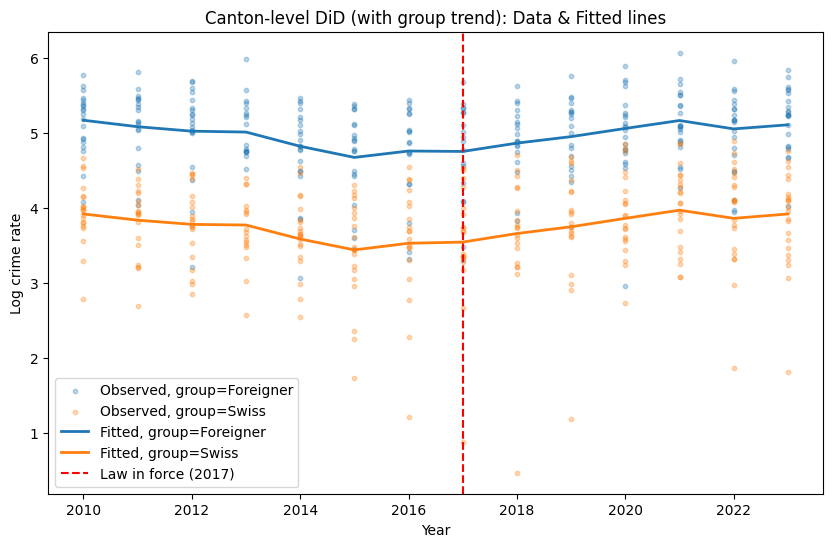

In [144]:

# 2) Put fitted values back into df_ct (not df!)
df_ct['fitted'] = mod2.fittedvalues

# 3) Scatter the raw canton-year log_rates
plt.figure(figsize=(10,6))
for grp_label, grp_df in df_ct.groupby('group'):
    plt.scatter(
        grp_df['year'],
        grp_df['log_rate'],
        alpha=0.3,
        s=10,
        label=f"Observed, group={grp_label}"
    )

# 4) Compute average fitted trajectory by group and year
#    (mod2.predict already uses T_P and T_t from df_ct)
avg_fit = (
    df_ct
    .groupby(['group','year'])
    .agg(log_rate_obs=('log_rate','mean'),
         fitted_mean=('fitted','mean'))
    .reset_index()
)

# 5) Plot the two fitted lines
for grp_label, grp_df in avg_fit.groupby('group'):
    plt.plot(
        grp_df['year'],
        grp_df['fitted_mean'],
        linewidth=2,
        label=f"Fitted, group={grp_label}"
    )

# 6) Add treatment date
plt.axvline(2017, color='red', linestyle='--', label='Law in force (2017)')
plt.xlabel('Year')
plt.ylabel('Log crime rate')
plt.title('Canton-level DiD (with group trend): Data & Fitted lines')
plt.legend()
plt.show()

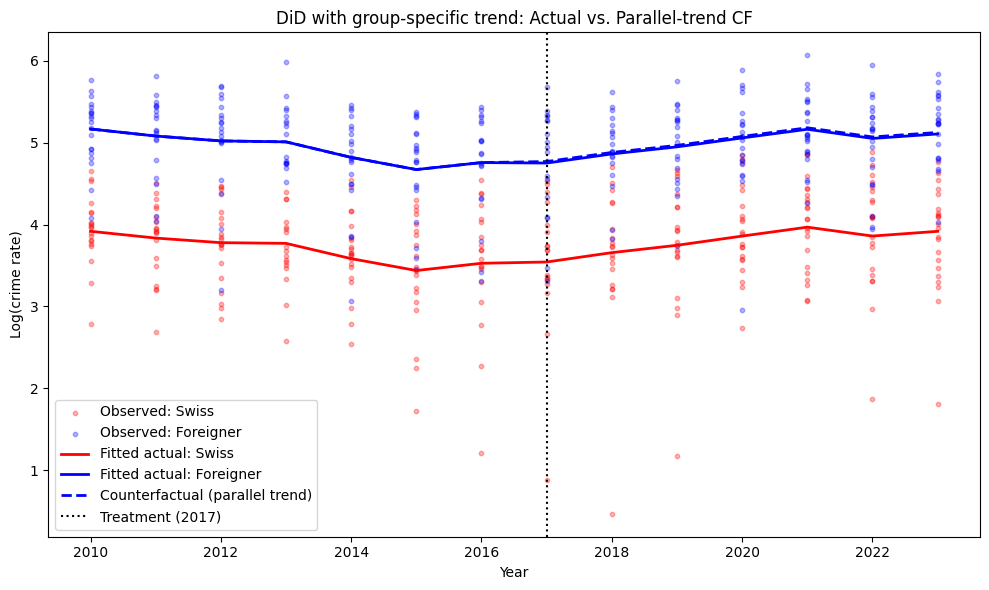

In [145]:
# Build a “counterfactual” dataset where Foreigner keeps its pre-treatment trend:
df_ct_cf = df_ct.copy()

# zero out the post dummy so the Foreigner×Post jump vanishes
df_ct_cf['T_P'] = 0

# keep the group‐specific trend term intact (so slope continues)
# T_t is just time × Foreigner, so it stays

# Predict both actual and counterfactual paths
df_ct['f_actual'] = mod2.predict(df_ct)
df_ct_cf['f_cf']    = mod2.predict(df_ct_cf)

# Aggregate to year × group means
agg = (
    df_ct
    .assign(f_cf=df_ct_cf['f_cf'])
    .groupby(['group','year'])
    .agg(obs_rate=('log_rate','mean'),
         fit_actual=('f_actual','mean'),
         fit_cf    =('f_cf','mean'))
    .reset_index())

plt.figure(figsize=(10,6))

# scatter raw, by group
for grp, color in [('Swiss','red'), ('Foreigner','blue')]:
    sub = df_ct[df_ct['group'] == grp]
    plt.scatter(sub['year'], sub['log_rate'],
                color=color, alpha=0.3, s=10,
                label=f'Observed: {grp}')

# lines for control and treated
for grp, color in [('Swiss','red'), ('Foreigner','blue')]:
    sub = agg[agg['group']==grp]
    plt.plot(sub['year'], sub['fit_actual'], color=color, lw=2,
             label=f'Fitted actual: {grp}')
    if grp=='Foreigner':
        plt.plot(sub['year'], sub['fit_cf'], color=color, lw=2, ls='--',
                 label='Counterfactual (parallel trend)')

# vertical treatment line
plt.axvline(2017, color='black', ls=':', lw=1.5, label='Treatment (2017)')

plt.xlabel('Year')
plt.ylabel('Log(crime rate)')
plt.title('DiD with group‐specific trend: Actual vs. Parallel‐trend CF')
plt.legend()
plt.tight_layout()
plt.show()


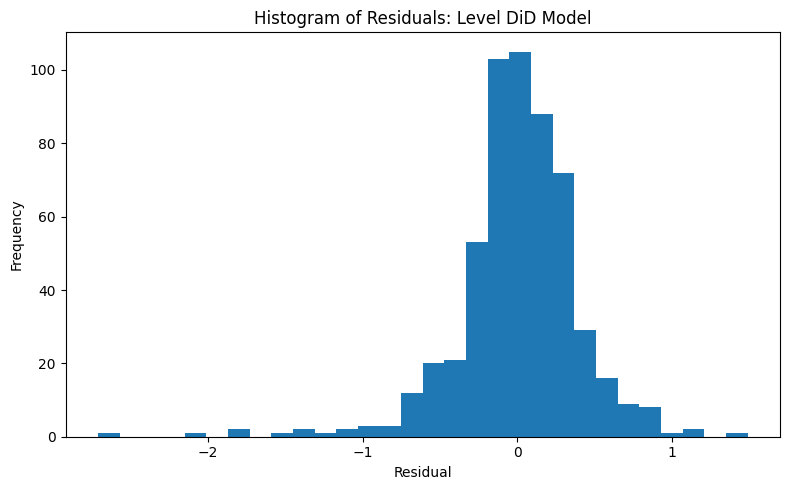

In [146]:
resid = mod2.resid

# Histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(resid, bins=30)
plt.title("Histogram of Residuals: Level DiD Model")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Treat outliers possible bias

In [147]:
#model with robust errors estimations
mod2_hc3 = mod2.get_robustcov_results(cov_type='HC3')
print(mod2_hc3.summary())

                            OLS Regression Results                            
Dep. Variable:               log_rate   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     57.25
Date:                Sun, 11 May 2025   Prob (F-statistic):          9.59e-160
Time:                        18:44:58   Log-Likelihood:                -278.74
No. Observations:                 556   AIC:                             635.5
Df Residuals:                     517   BIC:                             804.0
Df Model:                          38                                         
Covariance Type:                  HC3                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [148]:
#Huber fit regression -> outlier robust
import statsmodels.api as sm

# 1) Build your design matrices (same as for mod2)
y, X = smf.ols("log_rate ~ T_P + T_t + C(group) + C(canton) + C(year)",
               data=df_ct, return_type='dataframe').endog, \
       smf.ols("log_rate ~ T_P + T_t + C(group) + C(canton) + C(year)",
               data=df_ct, return_type='dataframe').exog

# 2) Fit an RLM with Huber’s T norm (for example)
rlm_mod = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()

print(rlm_mod.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  556
Model:                            RLM   Df Residuals:                      517
Method:                          IRLS   Df Model:                           38
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 11 May 2025                                         
Time:                        18:44:58                                         
No. Iterations:                    40                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1063      0.079     64.832      0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['return_type']
  warnings.warn(msg, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['return_type']
  warnings.warn(msg, ValueWarning)
